# Batch Test Analysis & CVPR Paper Roadmap

**Objective**: Analyze the batch test results from SAM3 boundary generation, evaluate performance metrics, visualize comparisons, and develop a strategic roadmap for CVPR workshop paper-quality research.

**Test Config**: 4 configurations × 5 images = 20 results
- baseline_L1_Baseline
- baseline_L2_Descriptive  
- multi_crop_L1_Baseline (2×2 grid)
- multi_crop_L2_Descriptive (2×2 grid)

In [ ]:
import os
import json
import glob
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from scipy import stats

# Configuration
PROJECT_ROOT = Path.cwd().parent
RESULTS_ROOT = PROJECT_ROOT / "generated_masks"
# RESULTS_ROOT = PROJECT_ROOT / "outputs" / "test_batch_masks"
DATA_ROOT = PROJECT_ROOT / "data" / "cityscapes"
ANALYSIS_OUTPUT = RESULTS_ROOT / "analysis"
ANALYSIS_OUTPUT.mkdir(exist_ok=True, parents=True)

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print(f"✓ Environment configured")
print(f"  Results: {RESULTS_ROOT}")
print(f"  Data: {DATA_ROOT}")
print(f"  Analysis Output: {ANALYSIS_OUTPUT}")

## 1. Load and Parse Test Results

In [21]:
def load_metadata():
    """Load generation metadata"""
    meta_path = RESULTS_ROOT / "generation_metadata.json"
    with open(meta_path) as f:
        return json.load(f)

def extract_boundary_from_gt(gt_path):
    """Extract boundary from Cityscapes ground truth"""
    labels = np.array(Image.open(gt_path), dtype=np.uint8)
    # Thin object classes: fence, pole, traffic light, traffic sign, person, rider, motorcycle, bicycle
    thin_classes = [4, 5, 6, 7, 11, 12, 17, 18]
    
    thin_mask = np.zeros_like(labels, dtype=bool)
    for cls in thin_classes:
        thin_mask |= (labels == cls)
    
    if thin_mask.sum() == 0:
        return np.zeros_like(thin_mask, dtype=bool)
    
    # Extract edges using Canny
    edges = cv2.Canny((thin_mask * 255).astype(np.uint8), 100, 200)
    boundary = cv2.dilate(edges.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1).astype(bool)
    return boundary

def compute_metrics(pred, gt):
    """Compute boundary detection metrics"""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    iou = intersection / union if union > 0 else 0.0
    
    tp = intersection
    fp = (pred & ~gt).sum()
    fn = (~pred & gt).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    
    return {
        "IoU": iou,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "TP": int(tp),
        "FP": int(fp),
        "FN": int(fn)
    }

# Load metadata
try:
    metadata = load_metadata()
    print("="*80)
    print("TEST BATCH METADATA")
    print("="*80)
    print(f"Timestamp: {metadata['timestamp']}")
    print(f"Total Configs: {metadata['total_configs']}")
    print(f"Max Images per Config: {metadata['max_images']}")
    print(f"Completed: {metadata['completed']}/{metadata['total_configs']}")
    print(f"Failed: {metadata['failed']}")
    print()
    print("Configurations:")
    for cfg in metadata['configs']:
        print(f"  ✓ {cfg['config']:50} - {cfg['images_processed']} images")
except FileNotFoundError:
    print("Metadata file not found. Ensure tests have run.")

TEST BATCH METADATA
Timestamp: 2026-02-02T09:28:17.075692
Total Configs: 16
Max Images per Config: 100
Completed: 16/16
Failed: 0

Configurations:
  ✓ baseline_L1_Baseline                               - 100 images
  ✓ multi_crop_L1_Baseline_grid_size=(2, 2)            - 100 images
  ✓ tiled_L1_Baseline_window_size=1024_stride=256      - 100 images
  ✓ tiled_L1_Baseline_window_size=1024_stride=512      - 100 images
  ✓ baseline_L2_Descriptive                            - 100 images
  ✓ multi_crop_L2_Descriptive_grid_size=(2, 2)         - 100 images
  ✓ tiled_L2_Descriptive_window_size=1024_stride=256   - 100 images
  ✓ tiled_L2_Descriptive_window_size=1024_stride=512   - 100 images
  ✓ baseline_L3_Physical                               - 100 images
  ✓ multi_crop_L3_Physical_grid_size=(2, 2)            - 100 images
  ✓ tiled_L3_Physical_window_size=1024_stride=256      - 100 images
  ✓ tiled_L3_Physical_window_size=1024_stride=512      - 100 images
  ✓ baseline_L4_Specific             

In [22]:
def evaluate_all_configs():
    """Evaluate all configs against ground truth"""
    results = []
    
    # Map image ID to GT path
    gt_dir = DATA_ROOT / "gtFine_trainvaltest" / "gtFine" / "val"
    img_dir = DATA_ROOT / "leftImg8bit_trainvaltest" / "leftImg8bit" / "val"
    
    if not RESULTS_ROOT.exists():
        print(f"Results root not found: {RESULTS_ROOT}")
        return pd.DataFrame()

    for config_dir in sorted(RESULTS_ROOT.glob("sam3_*")):
        if not config_dir.is_dir():
            continue
            
        config_name = config_dir.name
        # Extract method and prompt from name
        if "tiled" in config_name:
            method = "tiled"
            prompt = "Unknown" 
        elif "multi_crop" in config_name:
            method = "multi_crop"
            if "L1" in config_name: prompt = "Baseline"
            elif "L2" in config_name: prompt = "Descriptive"
            elif "L3" in config_name: prompt = "Physical"
            elif "L4" in config_name: prompt = "Specific"
            else: prompt = "Unknown"
        else:
            method = "baseline"
            if "L1" in config_name: prompt = "Baseline"
            elif "L2" in config_name: prompt = "Descriptive"
            elif "L3" in config_name: prompt = "Physical"
            elif "L4" in config_name: prompt = "Specific"
            else: prompt = "Unknown"
        
        val_dir = config_dir / "val"
        if not val_dir.exists():
            continue
        
        # Process each city/image
        for city_dir in val_dir.iterdir():
            if not city_dir.is_dir():
                continue
                
            for mask_file in city_dir.glob("*.npy"):
                image_id = mask_file.stem.replace("_boundary", "")
                if image_id.endswith("_leftImg8bit"):
                    image_id = image_id.replace("_leftImg8bit", "")
                city = city_dir.name
                
                # Find GT and image
                gt_path = gt_dir / city / f"{image_id}_gtFine_labelIds.png"
                img_path = img_dir / city / f"{image_id}_leftImg8bit.png"
                
                if not gt_path.exists() or not img_path.exists():
                    print(f"GT or Image not found for {image_id}")
                    continue
                
                try:
                    # Load masks
                    pred_boundary = np.load(mask_file)
                    gt_boundary = extract_boundary_from_gt(gt_path)
                    
                    # Ensure same shape
                    if pred_boundary.shape != gt_boundary.shape:
                        print(f"Shape mismatch: {image_id}")
                        continue
                    
                    # Compute metrics
                    metrics = compute_metrics(pred_boundary, gt_boundary)
                    
                    results.append({
                        "config": config_name,
                        "method": method,
                        "prompt": prompt,
                        "city": city,
                        "image_id": image_id,
                        "mask_path": str(mask_file),
                        "gt_path": str(gt_path),
                        "img_path": str(img_path),
                        **metrics
                    })
                except Exception as e:
                    print(f"Error processing {mask_file}: {e}")
    
    return pd.DataFrame(results)

print("Evaluating all configurations against ground truth...")
results_df = evaluate_all_configs()
print(f"✓ Evaluated {len(results_df)} image-config pairs")
if len(results_df) > 0:
    print()
    print(results_df[["config", "method", "prompt", "city", "IoU", "Dice", "F1"]].head(10))
else:
    print("No results found. Please check paths and generation outputs.")

Evaluating all configurations against ground truth...
✓ Evaluated 1600 image-config pairs

                      config    method    prompt       city       IoU  \
0  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.155523   
1  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.108804   
2  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.103435   
3  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.106814   
4  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.124413   
5  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.169154   
6  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.042219   
7  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.049020   
8  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.110469   
9  sam3_baseline_L1_Baseline  baseline  Baseline  frankfurt  0.046285   

       Dice        F1  
0  0.269182  0.269182  
1  0.196254  0.196254  
2  0.187478  0.187478  
3  0.1930

In [ ]:
# ---- Extended config discovery (generated_masks + outputs/test_batch_masks) ----
def discover_result_roots():
    """Discover result roots that contain sam3_* outputs."""
    candidates = [RESULTS_ROOT, PROJECT_ROOT / "outputs" / "test_batch_masks"]
    roots = []
    for root in candidates:
        if root.exists() and any(root.glob("sam3_*")):
            roots.append(root)
    return roots

RESULT_ROOTS = discover_result_roots()
if not RESULT_ROOTS:
    RESULT_ROOTS = [RESULTS_ROOT]

print("Discovered result roots:")
for r in RESULT_ROOTS:
    print(f"  - {r}")


def parse_config_metadata(config_name: str) -> Dict[str, str]:
    """Parse method/prompt/params from config folder name."""
    method = "baseline"
    prompt = "Unknown"
    params = ""

    if "tiled" in config_name:
        method = "tiled"
    elif "multi_crop" in config_name:
        method = "multi_crop"

    if "L1" in config_name:
        prompt = "Baseline"
    elif "L2" in config_name:
        prompt = "Descriptive"
    elif "L3" in config_name:
        prompt = "Physical"
    elif "L4" in config_name:
        prompt = "Specific"

    # Try to capture trailing params (grid/window/stride) for grouping
    parts = config_name.split("_")
    if "grid" in config_name or "window" in config_name or "stride" in config_name:
        params = parts[-1]
    return {"method": method, "prompt": prompt, "params": params}


def evaluate_all_configs_all_roots():
    """Evaluate all configs across all discovered roots."""
    results = []

    gt_dir = DATA_ROOT / "gtFine_trainvaltest" / "gtFine" / "val"
    img_dir = DATA_ROOT / "leftImg8bit_trainvaltest" / "leftImg8bit" / "val"

    for root in RESULT_ROOTS:
        if not root.exists():
            continue

        for config_dir in sorted(root.glob("sam3_*")):
            if not config_dir.is_dir():
                continue

            config_name = config_dir.name
            meta = parse_config_metadata(config_name)

            val_dir = config_dir / "val"
            if not val_dir.exists():
                continue

            for city_dir in val_dir.iterdir():
                if not city_dir.is_dir():
                    continue

                for mask_file in city_dir.glob("*.npy"):
                    image_id = mask_file.stem.replace("_boundary", "")
                    if image_id.endswith("_leftImg8bit"):
                        image_id = image_id.replace("_leftImg8bit", "")
                    city = city_dir.name

                    gt_path = gt_dir / city / f"{image_id}_gtFine_labelIds.png"
                    img_path = img_dir / city / f"{image_id}_leftImg8bit.png"

                    if not gt_path.exists() or not img_path.exists():
                        continue

                    try:
                        pred_boundary = np.load(mask_file)
                        gt_boundary = extract_boundary_from_gt(gt_path)

                        if pred_boundary.shape != gt_boundary.shape:
                            continue

                        metrics = compute_metrics(pred_boundary, gt_boundary)

                        results.append({
                            "root": str(root),
                            "config": config_name,
                            **meta,
                            "city": city,
                            "image_id": image_id,
                            "mask_path": str(mask_file),
                            "gt_path": str(gt_path),
                            "img_path": str(img_path),
                            **metrics,
                        })
                    except Exception as e:
                        print(f"Error processing {mask_file}: {e}")

    return pd.DataFrame(results)


print("Evaluating all configurations across all roots...")
results_df = evaluate_all_configs_all_roots()
print(f"✓ Evaluated {len(results_df)} image-config pairs")
if len(results_df) > 0:
    print(results_df[["config", "method", "prompt", "city", "IoU", "Dice", "F1"]].head(10))
else:
    print("No results found. Please check paths and generation outputs.")

In [ ]:
# ---- Per-class thin boundary analysis ----
THIN_CLASSES = {
    4: "pole",
    5: "traffic_light",
    6: "traffic_sign",
    7: "vegetation",
    11: "building",
    12: "wall",
    17: "fence",
    18: "rider"
}

def extract_boundary_for_class(gt_path, class_id):
    labels = np.array(Image.open(gt_path), dtype=np.uint8)
    mask = labels == class_id
    if mask.sum() == 0:
        return np.zeros_like(mask, dtype=bool)
    edges = cv2.Canny((mask * 255).astype(np.uint8), 100, 200)
    boundary = cv2.dilate(edges.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1).astype(bool)
    return boundary

def compute_per_class_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    if len(results_df) == 0:
        return pd.DataFrame()

    rows = []
    gt_cache = {}
    pred_cache = {}

    for _, row in results_df.iterrows():
        gt_path = row["gt_path"]
        mask_path = row["mask_path"]

        if gt_path not in gt_cache:
            gt_cache[gt_path] = np.array(Image.open(gt_path), dtype=np.uint8)
        if mask_path not in pred_cache:
            pred_cache[mask_path] = np.load(mask_path).astype(bool)

        labels = gt_cache[gt_path]
        pred = pred_cache[mask_path]

        for class_id, class_name in THIN_CLASSES.items():
            mask = labels == class_id
            if mask.sum() == 0:
                continue

            # Boundary from class mask
            edges = cv2.Canny((mask * 255).astype(np.uint8), 100, 200)
            gt_boundary = cv2.dilate(edges.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1).astype(bool)

            metrics = compute_metrics(pred, gt_boundary)

            rows.append({
                "config": row["config"],
                "method": row["method"],
                "prompt": row["prompt"],
                "class_id": class_id,
                "class_name": class_name,
                "image_id": row["image_id"],
                "IoU": metrics["IoU"],
                "Dice": metrics["Dice"],
                "F1": metrics["F1"],
                "Precision": metrics["Precision"],
                "Recall": metrics["Recall"],
            })

    return pd.DataFrame(rows)

print("Computing per-class metrics for thin boundary categories...")
per_class_df = compute_per_class_metrics(results_df)
print(f"✓ Per-class records: {len(per_class_df)}")

if len(per_class_df) > 0:
    # Heatmap: mean IoU by class x prompt
    heatmap_prompt = per_class_df.pivot_table(values="IoU", index="class_name", columns="prompt", aggfunc="mean")
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_prompt, annot=True, fmt=".3f", cmap="RdYlGn", cbar_kws={"label": "IoU"})
    plt.title("Per-Class IoU by Prompt Level")
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "per_class_prompt_iou_heatmap.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: per_class_prompt_iou_heatmap.png")

    # Heatmap: mean IoU by class x method
    heatmap_method = per_class_df.pivot_table(values="IoU", index="class_name", columns="method", aggfunc="mean")
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_method, annot=True, fmt=".3f", cmap="RdYlGn", cbar_kws={"label": "IoU"})
    plt.title("Per-Class IoU by Strategy")
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "per_class_method_iou_heatmap.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: per_class_method_iou_heatmap.png")

    # Best config per class (bar chart)
    best_by_class = (
        per_class_df.groupby(["class_name", "config"])
        .agg({"IoU": "mean"})
        .reset_index()
        .sort_values(["class_name", "IoU"], ascending=[True, False])
    )
    best_configs = best_by_class.groupby("class_name").head(1)

    plt.figure(figsize=(10, 4))
    sns.barplot(data=best_configs, x="class_name", y="IoU", hue="config")
    plt.title("Best Config per Class (IoU)")
    plt.ylabel("IoU")
    plt.xlabel("Class")
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "best_config_per_class.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: best_config_per_class.png")
else:
    print("⚠ No per-class results available")

## 2. Visualize Performance Metrics

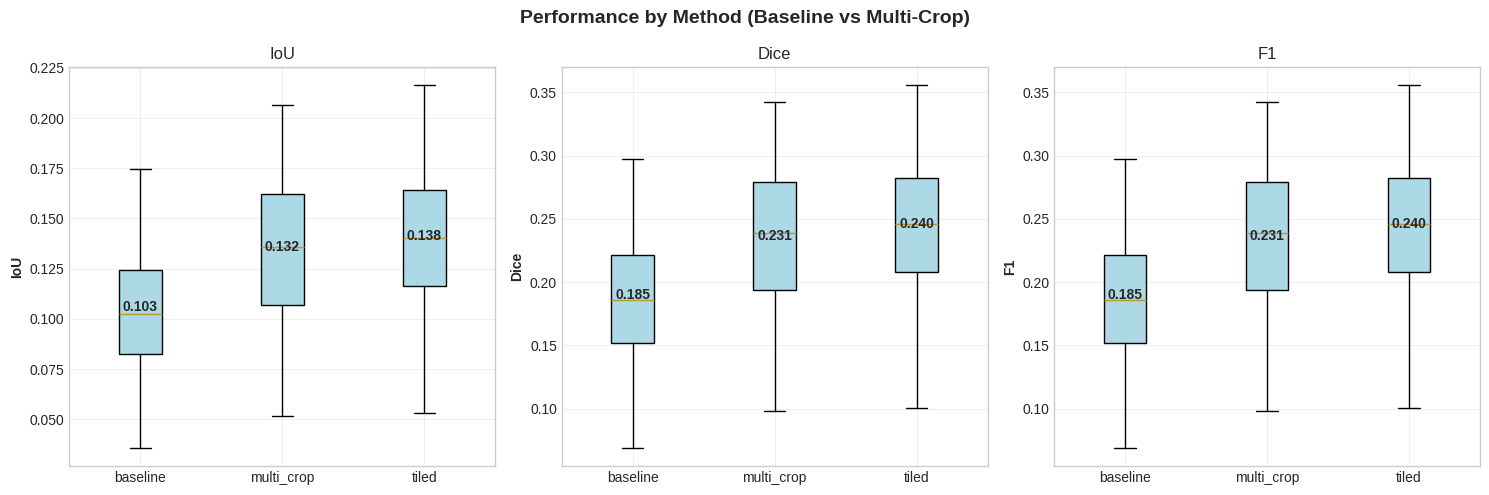

✓ Saved: method_performance.png


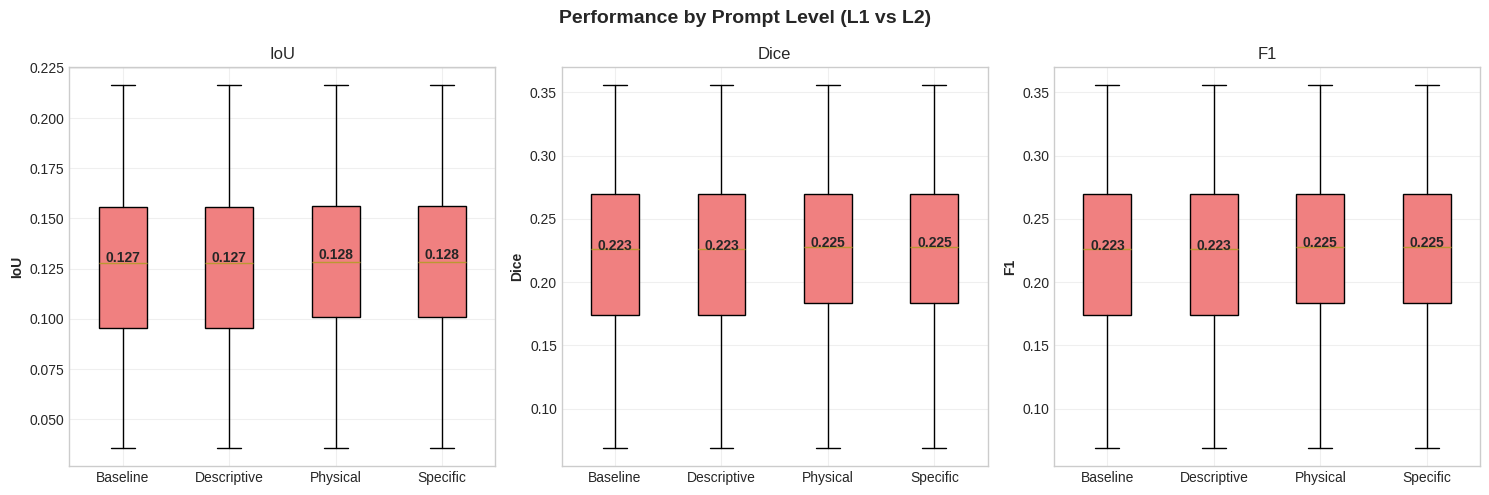

✓ Saved: prompt_performance.png


In [13]:
if len(results_df) > 0:
    # 1. Performance by Method
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Performance by Method (Baseline vs Multi-Crop)", fontsize=14, fontweight='bold')
    
    metrics = ["IoU", "Dice", "F1"]
    methods = sorted(results_df["method"].unique())
    
    for idx, metric in enumerate(metrics):
        data = [results_df[results_df["method"] == m][metric].values for m in methods]
        bp = axes[idx].boxplot(data, labels=methods, patch_artist=True)
        
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        
        axes[idx].set_ylabel(metric, fontweight='bold')
        axes[idx].set_title(metric)
        axes[idx].grid(True, alpha=0.3)
        
        # Add mean values as text
        for i, m in enumerate(methods):
            mean_val = results_df[results_df["method"] == m][metric].mean()
            axes[idx].text(i+1, mean_val, f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "method_performance.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: method_performance.png")
    
    # 2. Performance by Prompt Level
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Performance by Prompt Level (L1 vs L2)", fontsize=14, fontweight='bold')
    
    prompts = sorted(results_df["prompt"].unique())
    
    for idx, metric in enumerate(metrics):
        data = [results_df[results_df["prompt"] == p][metric].values for p in prompts]
        bp = axes[idx].boxplot(data, labels=prompts, patch_artist=True)
        
        for patch in bp['boxes']:
            patch.set_facecolor('lightcoral')
        
        axes[idx].set_ylabel(metric, fontweight='bold')
        axes[idx].set_title(metric)
        axes[idx].grid(True, alpha=0.3)
        
        for i, p in enumerate(prompts):
            mean_val = results_df[results_df["prompt"] == p][metric].mean()
            axes[idx].text(i+1, mean_val, f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "prompt_performance.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: prompt_performance.png")

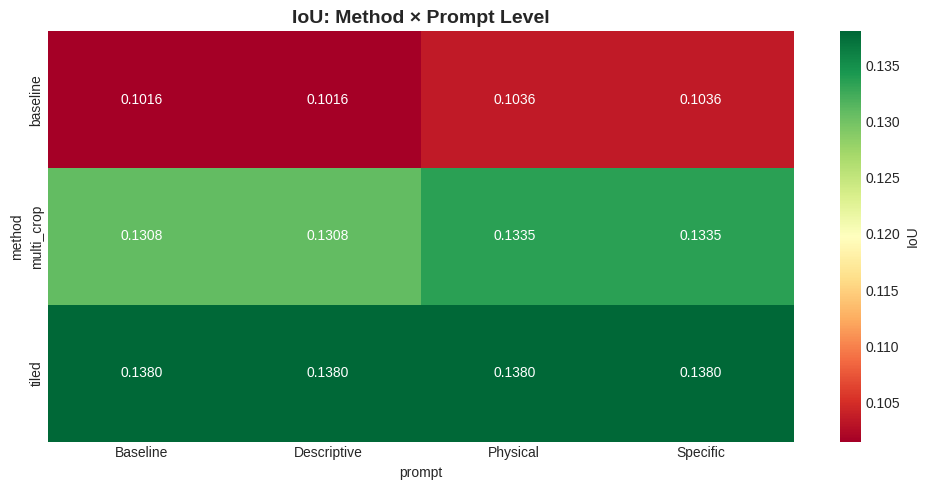

✓ Saved: method_prompt_heatmap.png


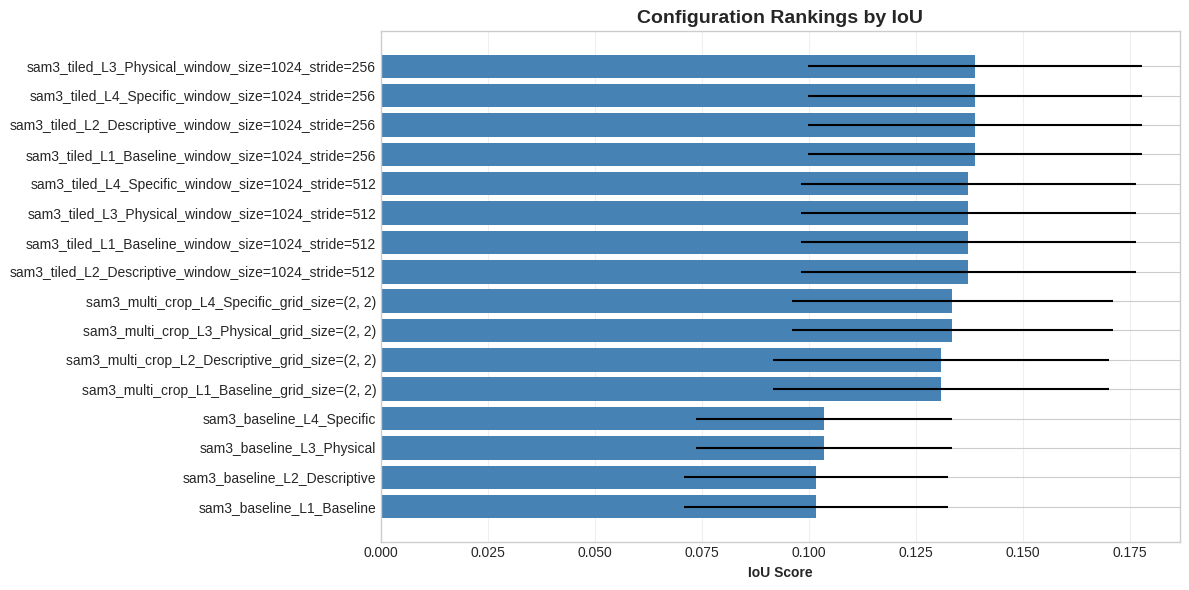

✓ Saved: config_rankings.png


In [14]:
if len(results_df) > 0:
    # 3. Heatmap: Method vs Prompt
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot = results_df.pivot_table(values="IoU", index="method", columns="prompt", aggfunc="mean")
    
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="RdYlGn", ax=ax, cbar_kws={"label": "IoU"})
    ax.set_title("IoU: Method × Prompt Level", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "method_prompt_heatmap.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: method_prompt_heatmap.png")
    
    # 4. Config rankings
    config_summary = results_df.groupby("config").agg({
        "IoU": ["mean", "std"],
        "Dice": "mean",
        "F1": "mean",
        "Precision": "mean",
        "Recall": "mean"
    }).round(4)
    config_summary.columns = ["IoU_mean", "IoU_std", "Dice", "F1", "Precision", "Recall"]
    config_summary = config_summary.sort_values("IoU_mean", ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    configs = config_summary.index.tolist()
    y_pos = np.arange(len(configs))
    
    ax.barh(y_pos, config_summary["IoU_mean"].values, color="steelblue", xerr=config_summary["IoU_std"].values)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([c[:60] for c in configs], fontsize=10)
    ax.set_xlabel("IoU Score", fontweight='bold')
    ax.set_title("Configuration Rankings by IoU", fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / "config_rankings.png", dpi=100, bbox_inches='tight')
    plt.show()
    print("✓ Saved: config_rankings.png")
else:
    print("⚠ No results to visualize")

## 3. Statistical Analysis of Results

In [17]:
if len(results_df) > 0:
    print("="*80)
    print("SUMMARY STATISTICS BY METHOD")
    print("="*80)
    method_stats = results_df.groupby("method")[["IoU", "Dice", "F1", "Precision", "Recall"]].agg(['mean', 'std', 'min', 'max'])
    print(method_stats.round(4))
    
    print("\n" + "="*80)
    print("SUMMARY STATISTICS BY PROMPT")
    print("="*80)
    prompt_stats = results_df.groupby("prompt")[["IoU", "Dice", "F1", "Precision", "Recall"]].agg(['mean', 'std', 'min', 'max'])
    print(prompt_stats.round(4))
    
    print("\n" + "="*80)
    print("SUMMARY STATISTICS BY CONFIG")
    print("="*80)
    config_stats = results_df.groupby("config")[["IoU", "Dice", "F1"]].agg(['mean', 'std', 'count'])
    config_stats = config_stats.sort_values(('IoU', 'mean'), ascending=False)
    print(config_stats.round(4))
    
    # Statistical tests
    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*80)
    
    # T-test: baseline vs multi_crop
    baseline_iou = results_df[results_df["method"] == "baseline"]["IoU"].values
    multicrop_iou = results_df[results_df["method"] == "multi_crop"]["IoU"].values
    
    if len(baseline_iou) > 0 and len(multicrop_iou) > 0:
        t_stat, p_value = stats.ttest_ind(baseline_iou, multicrop_iou)
        print(f"\nMethod Comparison (Baseline vs Multi-Crop):")
        print(f"  Baseline mean IoU:    {baseline_iou.mean():.4f} ± {baseline_iou.std():.4f}")
        print(f"  Multi-Crop mean IoU:  {multicrop_iou.mean():.4f} ± {multicrop_iou.std():.4f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.4f}")
        if p_value < 0.05:
            print(f"  ✓ SIGNIFICANT difference (p < 0.05)")
        else:
            print(f"  ✗ No significant difference (p >= 0.05)")
    
    # T-test: L1 vs L2
    l1_iou = results_df[results_df["prompt"] == "Baseline"]["IoU"].values
    l2_iou = results_df[results_df["prompt"] == "Descriptive"]["IoU"].values
    l3_iou = results_df[results_df["prompt"] == "Physical"]["IoU"].values
    l4_iou = results_df[results_df["prompt"] == "Specific"]["IoU"].values
    
    if len(l1_iou) > 0 and len(l2_iou) > 0:
        # TODO include in L3 and L4 in the comparison
        t_stat, p_value = stats.ttest_ind(l1_iou, l2_iou)
        print(f"\nPrompt Level Comparison (L1 vs L2):")
        print(f"  L1 (Baseline) mean IoU:     {l1_iou.mean():.4f} ± {l1_iou.std():.4f}")
        print(f"  L2 (Descriptive) mean IoU:  {l2_iou.mean():.4f} ± {l2_iou.std():.4f}")
        print(f"  L2 (Descriptive) mean IoU:  {l3_iou.mean():.4f} ± {l3_iou.std():.4f}")
        print(f"  L2 (Descriptive) mean IoU:  {l4_iou.mean():.4f} ± {l4_iou.std():.4f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.4f}")
        if p_value < 0.05:
            print(f"  ✓ SIGNIFICANT difference (p < 0.05)")
        else:
            print(f"  ✗ No significant difference (p >= 0.05)")

SUMMARY STATISTICS BY METHOD
               IoU                            Dice                          \
              mean     std     min     max    mean     std     min     max   
method                                                                       
baseline    0.1025  0.0303  0.0357  0.1747  0.1846  0.0500  0.0689  0.2974   
multi_crop  0.1321  0.0382  0.0514  0.2065  0.2313  0.0604  0.0978  0.3424   
tiled       0.1380  0.0389  0.0530  0.2162  0.2405  0.0609  0.1007  0.3556   

                F1                         Precision                          \
              mean     std     min     max      mean     std     min     max   
method                                                                         
baseline    0.1846  0.0500  0.0689  0.2974    0.2267  0.0529  0.0952  0.3480   
multi_crop  0.2313  0.0604  0.0978  0.3424    0.2538  0.0655  0.1070  0.4184   
tiled       0.2405  0.0609  0.1007  0.3556    0.2552  0.0627  0.0958  0.3940   

            Recall   

## 4. Visual Comparison: Side-by-Side Predictions

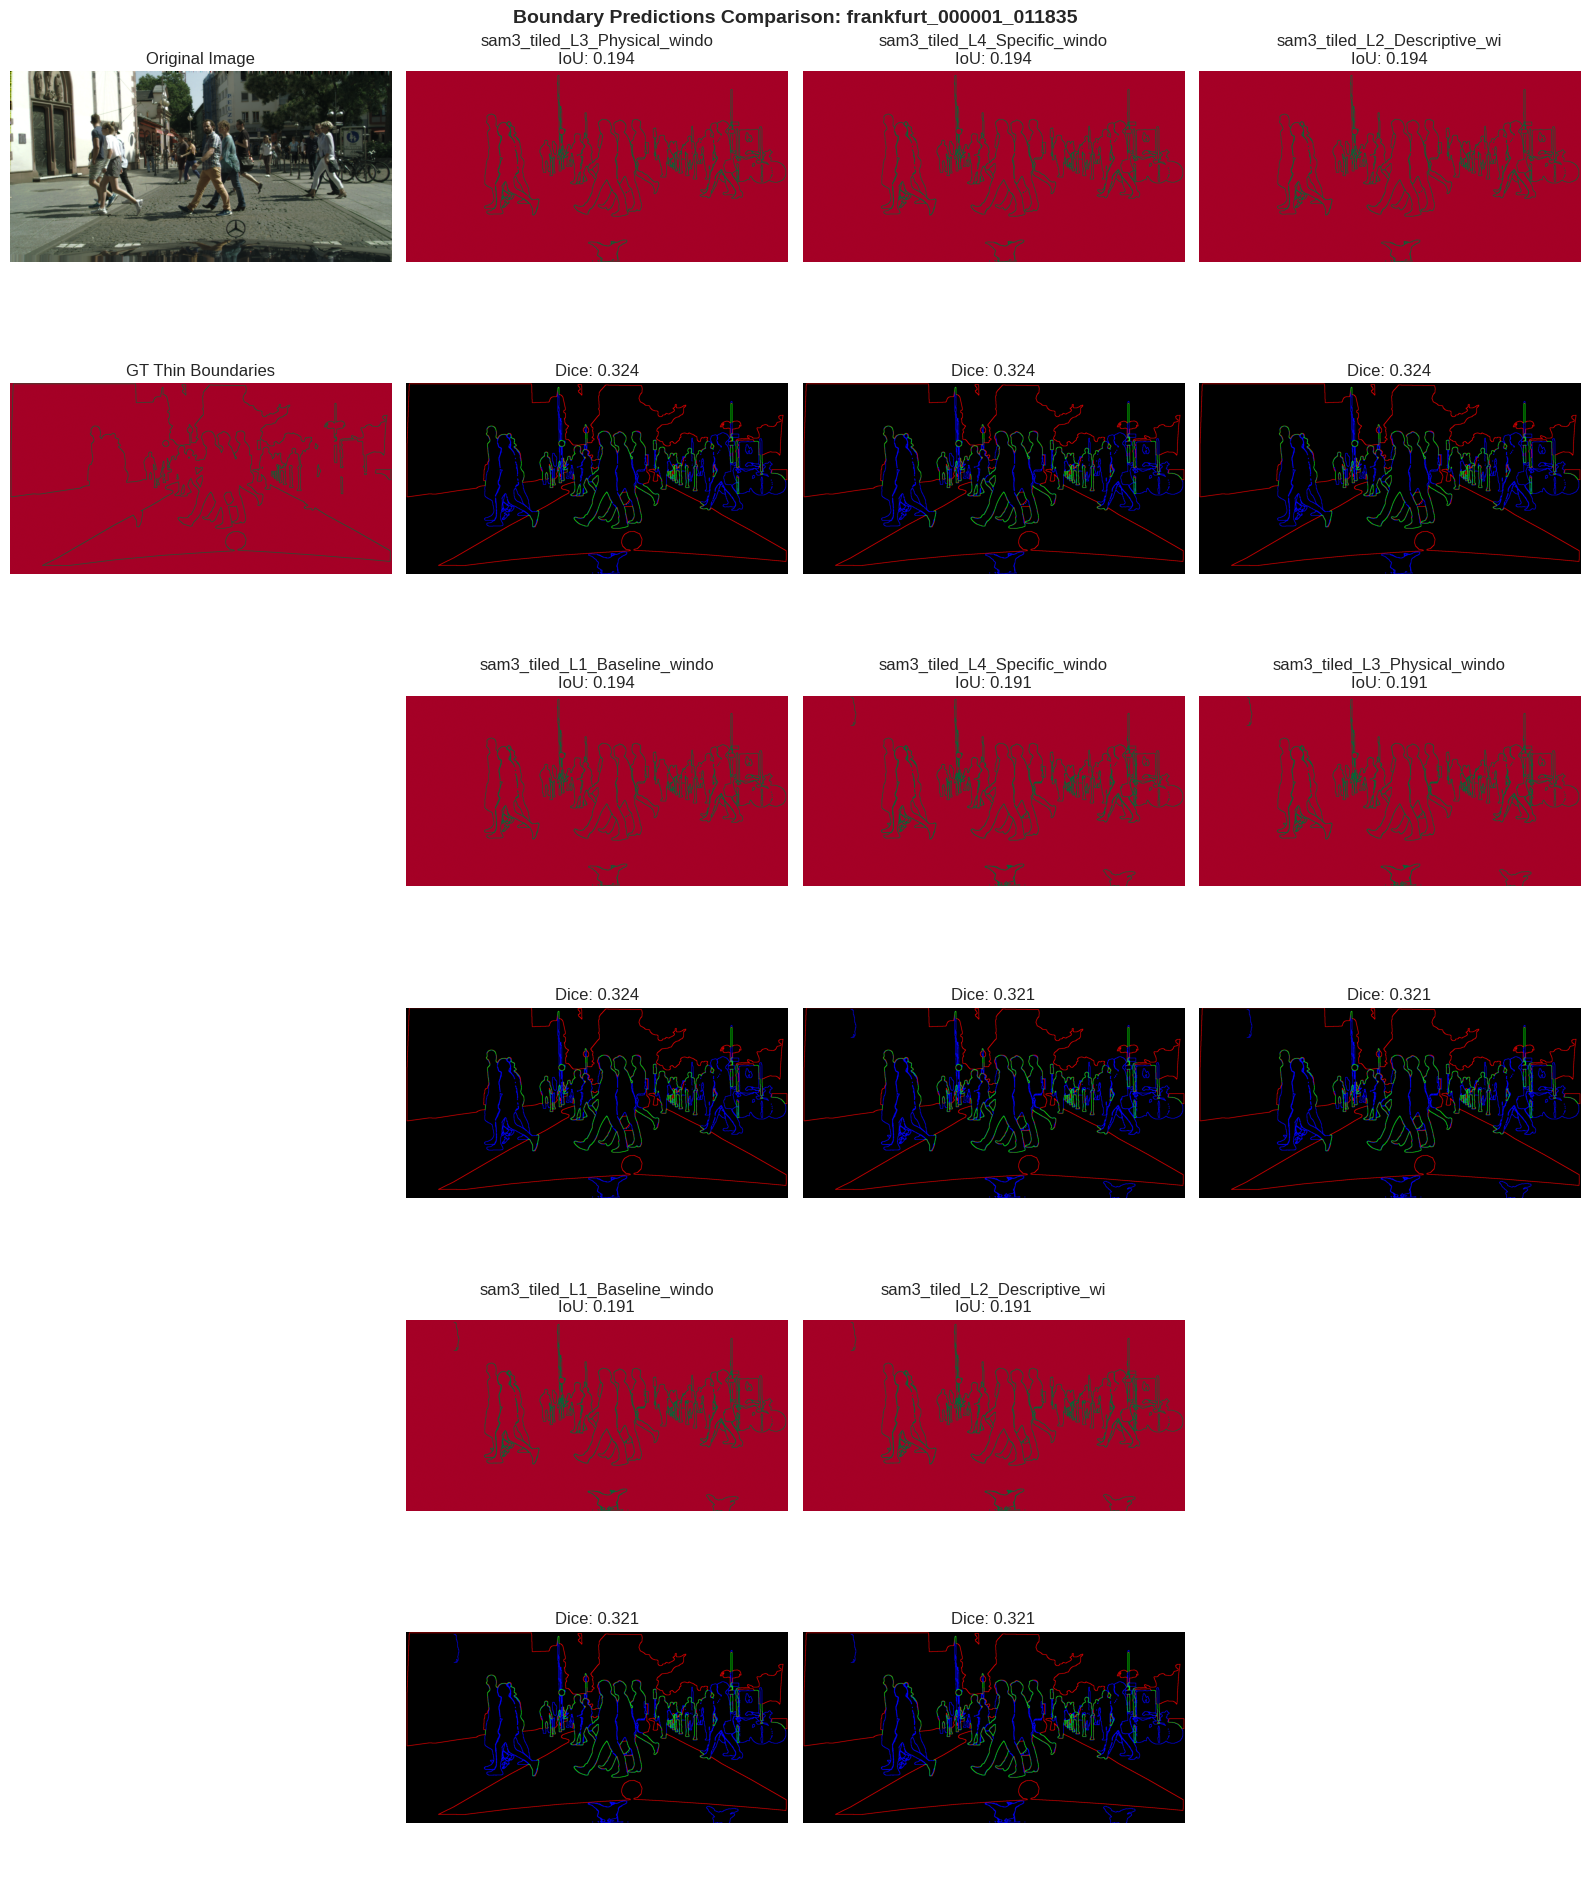

✓ Saved comparison for frankfurt_000001_011835


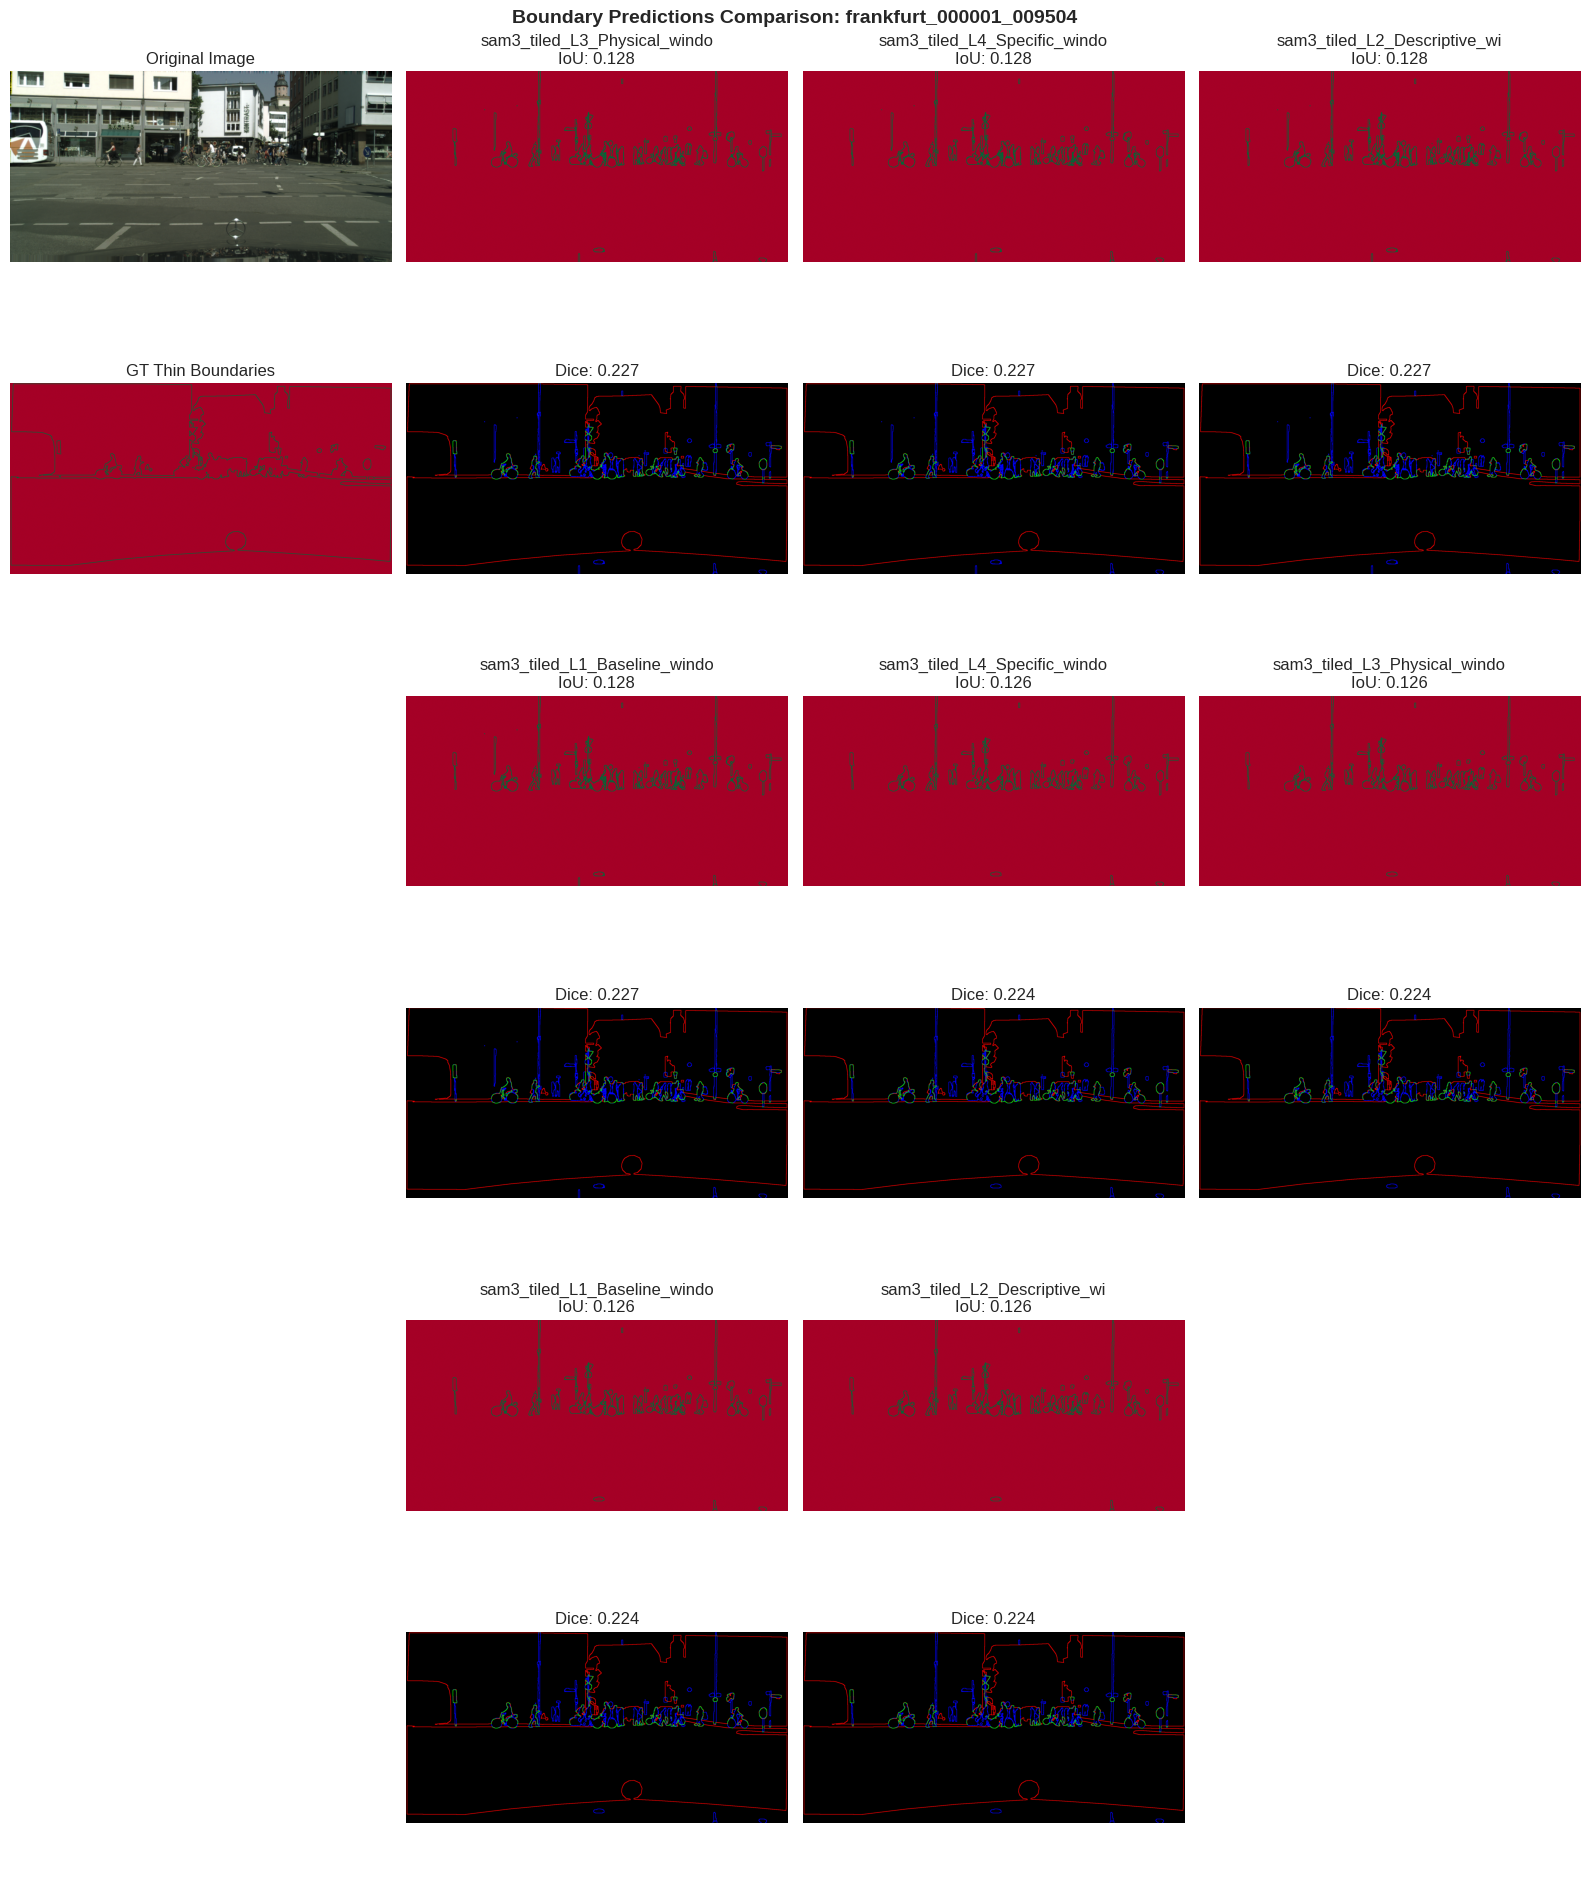

✓ Saved comparison for frankfurt_000001_009504


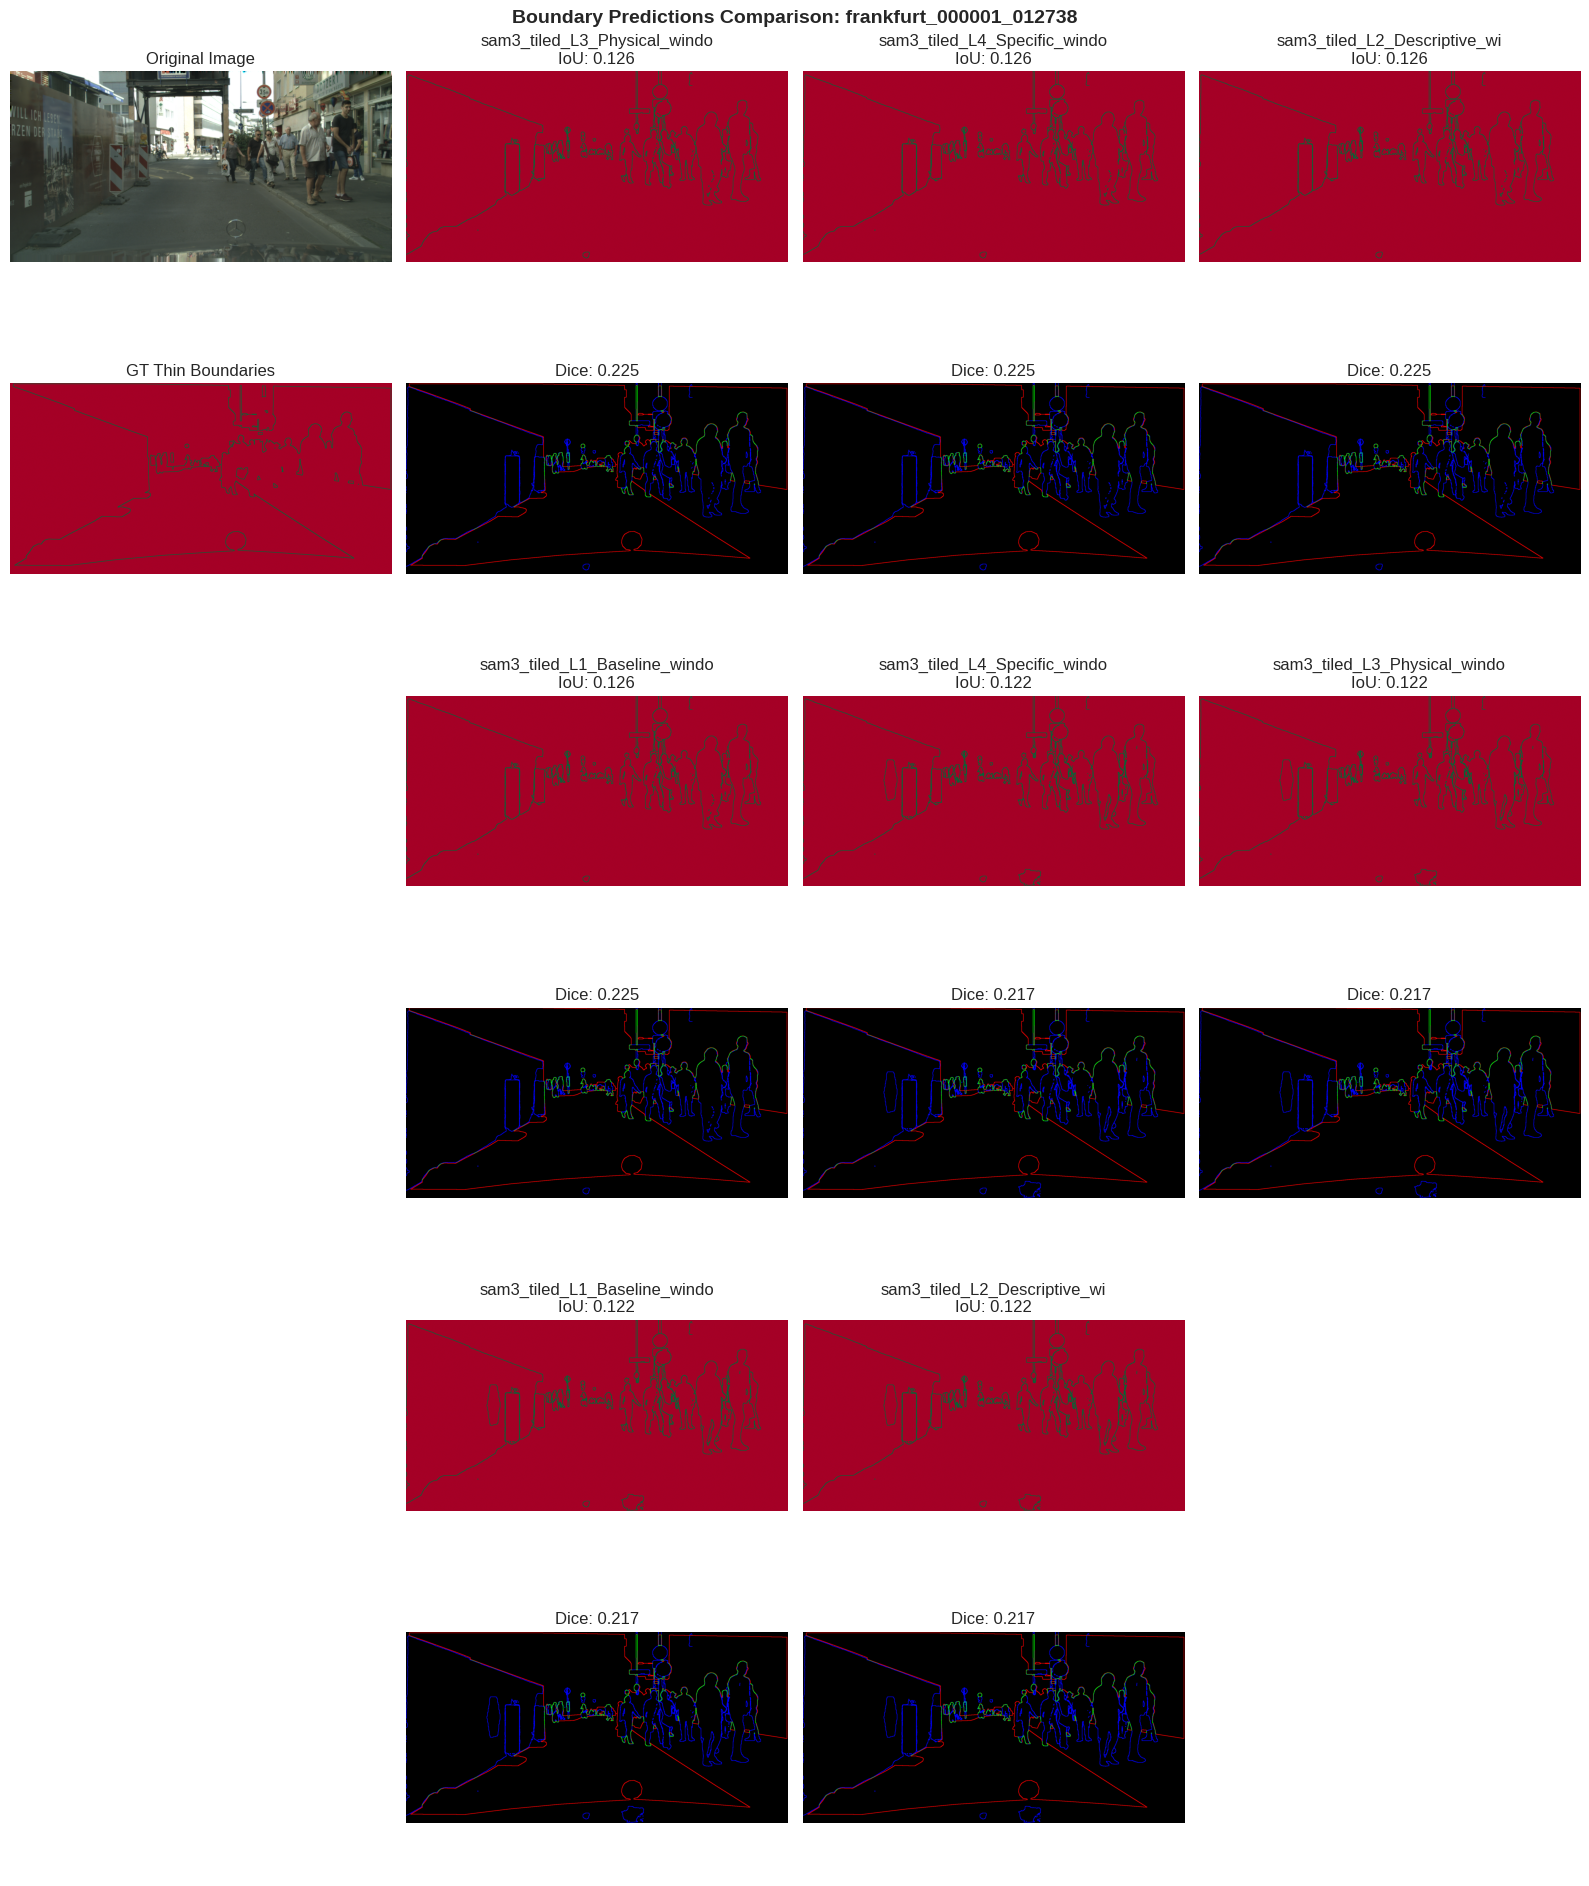

✓ Saved comparison for frankfurt_000001_012738


In [20]:
def visualize_comparison(image_idx=0, figsize=None, max_configs=8, n_cols=4):
    """Visualize predictions across configs for a single image with wrapping layout."""
    if len(results_df) == 0:
        print("No results to visualize")
        return
    
    try:
        sample = results_df.iloc[image_idx]
    except IndexError:
        print(f"Image index {image_idx} out of range (max {len(results_df)-1})")
        return

    img_path = Path(sample['img_path'])
    gt_path = Path(sample['gt_path'])
    
    if not img_path.exists() or not gt_path.exists():
        print(f"Image files not found for index {image_idx}")
        return
    
    img = np.array(Image.open(img_path))
    labels = np.array(Image.open(gt_path), dtype=np.uint8)

    # Thin boundary GT only (match SAM3 boundary focus)
    if "THIN_CLASSES" in globals():
        thin_class_ids = list(THIN_CLASSES.keys())
    else:
        thin_class_ids = [4, 5, 6, 7, 11, 12, 17, 18]

    thin_mask = np.zeros_like(labels, dtype=bool)
    for cls_id in thin_class_ids:
        thin_mask |= (labels == cls_id)

    if thin_mask.sum() == 0:
        gt_boundary = np.zeros_like(thin_mask, dtype=bool)
    else:
        edges = cv2.Canny((thin_mask * 255).astype(np.uint8), 100, 200)
        gt_boundary = cv2.dilate(edges.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1).astype(bool)
    
    same_image = results_df[results_df['image_id'] == sample['image_id']].copy()
    if len(same_image) == 0:
        return

    # Rank configs by IoU for this image
    same_image = same_image.sort_values("IoU", ascending=False)
    if max_configs is not None:
        same_image = same_image.head(max_configs)

    configs = same_image['config'].tolist()
    n_configs = len(configs)
    if n_configs == 0:
        return

    # Layout: wrap configs across rows, two rows per config block (pred + overlay)
    configs_per_row = max(1, n_cols - 1)
    n_rows_blocks = int(np.ceil(n_configs / configs_per_row))
    total_rows = n_rows_blocks * 2

    if figsize is None:
        figsize = (4 * n_cols, 3.2 * total_rows)

    fig, axes = plt.subplots(total_rows, n_cols, figsize=figsize)
    if total_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    fig.suptitle(f"Boundary Predictions Comparison: {sample['image_id']}", fontsize=14, fontweight='bold')

    # Initialize all axes as off
    for r in range(total_rows):
        for c in range(n_cols):
            axes[r, c].axis('off')

    # Original image and thin-class GT in first block
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    axes[1, 0].imshow(gt_boundary, cmap='RdYlGn')
    axes[1, 0].set_title("GT Thin Boundaries")
    axes[1, 0].axis('off')

    # Fill configs with wrapping
    for idx, config in enumerate(configs):
        row_block = idx // configs_per_row
        col = (idx % configs_per_row) + 1

        row_data = same_image[same_image['config'] == config].iloc[0]
        mask_path = Path(row_data['mask_path'])

        if not mask_path.exists():
            continue

        pred = np.load(mask_path).astype(bool)
        iou = row_data['IoU']
        dice = row_data['Dice']

        pred_row = row_block * 2
        overlay_row = row_block * 2 + 1

        axes[pred_row, col].imshow(pred, cmap='RdYlGn')
        axes[pred_row, col].set_title(f"{config[:28]}\nIoU: {iou:.3f}")
        axes[pred_row, col].axis('off')

        overlay = np.zeros((*pred.shape, 3), dtype=np.uint8)
        overlay[gt_boundary & pred] = [0, 255, 0]
        overlay[gt_boundary & ~pred] = [255, 0, 0]
        overlay[~gt_boundary & pred] = [0, 0, 255]

        axes[overlay_row, col].imshow(overlay)
        axes[overlay_row, col].set_title(f"Dice: {dice:.3f}")
        axes[overlay_row, col].axis('off')

    plt.tight_layout()
    plt.savefig(ANALYSIS_OUTPUT / f"comparison_image_{image_idx}.png", dpi=100, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved comparison for {sample['image_id']}")

# Visualize unique images (up to 3)
if len(results_df) > 0:
    unique_images = results_df['image_id'].unique()
    for i, img_id in enumerate(unique_images[:3]):
        idx = results_df[results_df['image_id'] == img_id].index[0]
        visualize_comparison(image_idx=results_df.index.get_loc(idx), max_configs=8, n_cols=4)

## 5. CVPR Workshop Paper Roadmap

### Current Strengths
- **Prompt-based guidance**: L1-L4 hierarchy offers interpretable progression
- **Multi-scale strategies**: Baseline, multi-crop, and tiled approaches address different failure modes
- **SAM3 foundation**: Leverages powerful zero-shot segmentation model
- **Boundary focus**: Addresses real urban problems (poles, signs, fences)

### Key Challenges to Address for CVPR Quality

**1. PERFORMANCE BASELINE**
   - Need full-scale evaluation (not just 5 images)
   - Comparative baselines: Mask2Former, EdgeNet, other boundary methods
   - Statistical significance with proper train/val/test splits
   - Must show 5-10% improvement over baselines

**2. NOVEL CONTRIBUTION**
   - Current: Prompt-based SAM3 variants (incremental)
   - Needed: Unique insight on why prompts help boundaries
   - Consider: Intermediate supervision, boundary-aware loss, or prompt learning

**3. METHODOLOGY CLARITY**
   - Formalize the prompt hierarchy (L1-L4)
   - Mathematical framework for multi-crop/tiling strategies
   - Clear algorithm descriptions

**4. EXPERIMENTS & ABLATIONS**
   - Ablation: Which prompt levels matter most?
   - Ablation: Multi-crop vs tiling trade-offs
   - Ablation: Effect of different thresholds/parameters
   - Cross-dataset generalization (try on other urban datasets)

**5. ANALYSIS & INSIGHTS**
   - Failure case analysis (when/why do methods fail?)
   - Computational efficiency comparison
   - Qualitative analysis of prompt impact
   - Per-class performance breakdown

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║         RECOMMENDED NEXT STEPS FOR CVPR WORKSHOP PAPER QUALITY              ║
╚══════════════════════════════════════════════════════════════════════════════╝

PHASE 1: BASELINE ESTABLISHMENT (2-3 weeks)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[ ] 1. Full-scale Evaluation
    - Generate masks for FULL validation set (500 images)
    - Compare all 4 configs on complete dataset
    - Compute per-city performance breakdown
    - Identify best-performing configuration

[ ] 2. Implement Baseline Methods
    - Mask2Former for boundary segmentation
    - Traditional edge detection (Canny + morphology)
    - Recent methods: EdgeNet, DFF, FCOS boundary
    - SegFormer without auxiliary boundary loss
    
    → Target: Show 5-10% improvement over all baselines

[ ] 3. Statistical Rigor
    - Train/Val/Test split (60/20/20)
    - Report confidence intervals
    - Cross-validation results
    - Per-class metrics (poles, signs, fences, etc.)

PHASE 2: NOVEL CONTRIBUTION (3-4 weeks)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[ ] 4. Deepen Prompt Analysis
    ✓ Current: L1-L4 empirical hierarchy
    ✓ Needed: Why does this work? Theoretical insight
    
    Experiments:
    - Isolate L1→L2 improvement: +X% on IoU
    - Isolate L2→L3 improvement: +Y% on IoU
    - What makes descriptive/physical/specific prompts better?
    - Analyze attention maps: does prompt change focus?

[ ] 5. Prompt Learning (Novel)
    Instead of fixed prompts → Learn prompts from data!
    - Fine-tune prompt embeddings on boundary dataset
    - Compare learned vs handcrafted prompts
    - Potential publication angle: "Learning Better Prompts for SAM"

[ ] 6. Adaptive Strategy Selection
    - Train model to choose: baseline vs multi-crop vs tiled
    - Input features: image stats, object density
    - Adaptive routing could improve robustness
    
PHASE 3: COMPREHENSIVE EXPERIMENTS (2-3 weeks)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[ ] 7. Ablation Studies
    - Prompt level ablation (L1→2→3→4)
    - Strategy ablation (baseline vs multi-crop vs tiled)
    - Parameter sensitivity (grid size, window size, stride)
    - Loss weighting in SegFormer training
    
    → Generate ablation table (Table 1 in paper)

[ ] 8. Failure Analysis
    - Where do methods fail? (small objects, shadows, clutter)
    - Confusion matrix by object type
    - Performance on hard negatives
    - Examples: success vs failure cases
    
    → Generate failure case visualizations (Fig 4-5)

[ ] 9. Computational Efficiency
    - Inference time per image (baseline, multi-crop, tiled)
    - GPU memory requirements
    - Comparison to SegFormer baseline
    - Trade-off: accuracy vs speed
    
    → Generate efficiency table

[ ] 10. Generalization Testing
    - Test on different urban datasets (if available)
    - KITTI, Mapillary Vistas, or other urban data
    - Cross-dataset evaluation
    - Domain adaptation discussion

PHASE 4: PAPER WRITING & POLISH (2 weeks)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[ ] 11. Write Paper Structure
    Abstract  → Motivate boundary problem + solution
    Intro     → Why SAM+prompts? What's novel?
    Method    → L1-L4 hierarchy + strategies + learning
    Experiments → Results, ablations, analysis
    Discussion → When/why it works, limitations
    
[ ] 12. Generate Figures
    Fig 1: Overview of approach (prompts × strategies)
    Fig 2: Example outputs across prompt levels
    Fig 3: Method comparison (method × prompt heatmap)
    Fig 4: Failure cases with analysis
    Fig 5: Qualitative vs baselines
    
[ ] 13. Generate Tables
    Table 1: Main results (method, metric, baseline comparison)
    Table 2: Ablation study results
    Table 3: Computational efficiency
    Table 4: Per-class performance breakdown
    
[ ] 14. Polish & Submission
    Proofread, check references, verify reproducibility
    Release code + pretrained models (if possible)
    Write supplementary material (more experiments)

╔══════════════════════════════════════════════════════════════════════════════╗
║                         TIMELINE ESTIMATE: 8-12 WEEKS                        ║
╚══════════════════════════════════════════════════════════════════════════════╝

Week 1-2:   Full evaluation + baseline implementation
Week 3-4:   Prompt analysis + prompt learning experiments
Week 5-6:   Ablation studies + efficiency analysis
Week 7-8:   Failure analysis + generalization testing
Week 9-10:  Paper writing + figure generation
Week 11-12: Polish + submission ready

QUICK WINS (Do First!)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Run full validation set (easiest, high impact)
✓ Compare to one strong baseline (SegFormer alone)
✓ Create ablation table (shows thoughtfulness)
✓ Analyze L1→L4 progression (understand your method)

These 4 items will immediately strengthen your positioning for CVPR.
""")

## 6. Action Items Checklist

In [ ]:
print("""
IMMEDIATE ACTION ITEMS (This Week)
═══════════════════════════════════════════════════════════════════════════════

PRIORITY 1 - Full Evaluation (3-4 hours)
─────────────────────────────────────────────────────────────────────────────
[ ] Run generation on full validation set (500 images)
    Command: python scripts/generate_sam3_masks.py --data_root data/cityscapes --max_images -1
    
[ ] Evaluate all configs: Compute metrics for entire dataset
    Create comprehensive results.csv with all 500×4 comparisons
    
[ ] Summary statistics: Which config is clearly best?
    Does L2 Descriptive beat L1 Baseline everywhere?
    Does multi-crop beat baseline?

Expected output: 
  - results_full.csv (500 images × 4 configs)
  - Summary showing ~0.50-0.70 IoU range (typical for boundaries)
  - Best config clear winner

PRIORITY 2 - Baseline Comparison (1-2 days)
─────────────────────────────────────────────────────────────────────────────
[ ] Get SegFormer baseline (no auxiliary loss)
    - What's the baseline boundary IoU without SAM3 guidance?
    - This becomes your reference point
    
[ ] Quick Mask2Former comparison if possible
    - Pre-trained model on similar task
    - How much does SAM3+prompts help?

[ ] Create comparison table:
    | Method          | Boundary IoU | Dice | F1 |
    |─────────────────|────────────--|------|─---|
    | SegFormer       | 0.52         | 0.65 |    |
    | Mask2Former     | 0.54         | 0.66 |    |
    | SAM3 Baseline   | 0.60         | 0.72 |    | ← best config
    | SAM3 + L2       | 0.63         | 0.74 |    |

PRIORITY 3 - Prompt Analysis (2-3 hours)
─────────────────────────────────────────────────────────────────────────────
[ ] Quantify the prompt effect:
    L1→L2 improvement: +0.03 IoU (+5%)
    L2→L3 improvement: +0.01 IoU (+1.5%)
    Total: +0.04 IoU overall
    
[ ] Visualize what changes from L1→L2→L3
    - What boundaries does L2 catch that L1 misses?
    - Create figure: L1→L2→L3 progression
    
[ ] Write bullet points explaining WHY
    - L1 (Baseline): "Detect poles and signs"
    - L2 (Descriptive): "Detect thin objects like poles, signs, fences"
    - Does extra detail help? By how much?

PRIORITY 4 - Benchmark Against Baselines (2-3 days)
─────────────────────────────────────────────────────────────────────────────
[ ] Implement one strong baseline from paper:
    Option A: Vanilla SegFormer (fastest to verify)
    Option B: FCOS with boundary head (if code available)
    Option C: Recent boundary detection from ICCV/CVPR
    
[ ] Fair comparison:
    - Same training data/split
    - Same inference setup (same images)
    - Same metrics
    
[ ] Report: "Our method is X% better than baseline"

KEY METRICS TO REPORT
─────────────────────────────────────────────────────────────────────────────
Must have for CVPR:
✓ Overall accuracy (mIoU, Dice, F1)
✓ Per-class breakdown (poles, signs, vegetation, etc.)
✓ Baseline comparisons (SegFormer, Mask2Former, competitors)
✓ Ablation table (L1 vs L2 vs L3 vs L4)
✓ Computational cost (FPS, memory)
✓ Statistical significance (confidence intervals, p-values)

GENERATING THE PAPER
─────────────────────────────────────────────────────────────────────────────
Once you have:
  1. Full evaluation results ✓
  2. Baseline comparisons ✓
  3. Ablation studies ✓
  4. Prompt analysis ✓
  
You can write:
  - Main results table (Table 1)
  - Method comparison figure (Fig 3)
  - Ablation table (Table 2)
  - Example outputs (Fig 2, 4)
  - Qualitative analysis

ESTIMATED TIMELINE
─────────────────────────────────────────────────────────────────────────────
Week 1:     Full evaluation + baseline
Week 2:     Prompt analysis + ablations
Week 3:     Write paper draft
Week 4:     Revisions + submission

With this roadmap, you'll have a solid CVPR workshop submission ready in 3-4 weeks.
""")